# Cluster analysis of the dynamic changes of allelic ratio over pseudotime

### Fig. 7C, 7D, Supp. Fig. 6A, 6B

In [5]:
#Loading libraries
suppressPackageStartupMessages({
    library(ggplot2)
    library(gridExtra)
    library(dplyr)
    library(plyr)
    library(openxlsx)
    library(ComplexHeatmap)
    library(reshape2)
    library(ggsci)
    library(RColorBrewer)
})

In [51]:
#Functions
#smoothing function
default_smooth_fun = function(x) {
	l = !is.na(x)
	if(sum(l) >= 2) {
		oe1 = try(x <- suppressWarnings(predict(locfit(x[l] ~ lp(seq_along(x)[l], nn = 0.1, h = 0.8)), seq_along(x))), silent = TRUE)
		if(inherits(oe1, "try-error")) {
			oe2 = try(x <-  suppressWarnings(predict(loess(x[l] ~ seq_along(x)[l], control = loess.control(surface = "direct")), seq_along(x))))

			if(inherits(oe2, "try-error")) {
				stop_wrap("error when doing locfit or loess smoothing")
			} else {
				return(x)
			}
		} else {
			return(x)
		}
	} else {
		stop_wrap("Too few data points.")
	}
	return(x)
}

plot_prep <- function(df, se){
    df$gene <- "1" #adding quasi variable "gene" to avoid conflict in ggplot
    df$AR_smooth <- default_smooth_fun(df$mean_AR)
    #calculating t-value for 95% CI
    df$t.val <- qt(0.975, length(df$AR_smooth) - 2)
    #calculating CI
    df$ci_upper_mean <- df$AR_smooth + df$t.val * se$se.fit
    df$ci_lower_mean <- df$AR_smooth - df$t.val * se$se.fit
    df
}

plot_mean_ci <- function(plot_mean){
    ggplot(plot_mean, aes(`pseudotime bin`, AR_smooth, group = gene)) +
    geom_line(color = "black", linewidth = 0.75) +
    geom_errorbar(aes(ymin=ci_lower_mean, ymax=ci_upper_mean), colour="darkgrey", width=.1, position=position_dodge(0.1)) +
    theme_classic(base_size = 20) +
    theme(legend.position = "none",  plot.subtitle = element_text(hjust = 1)) +
    theme(axis.title.x = element_blank(), panel.border = element_rect(colour = "black", fill=NA, size=1)) +
    scale_x_discrete(labels=seq(unique(plot_mean$`pseudotime bin`))) +
    labs(y = "Allelic Ratio", subtitle = paste0("Cluster ", seq(plot_mean))) +
    ylim(0,1) 
}


In [6]:
strains <- c("Cast", "Molf", "Pwk", "Spret")
hc <- readRDS("/data/hc_clust.rds")
trend_imputed <- readRDS("/data/trend_imputed_allstrains.rds")
trend_mats <- readRDS("/data/trend_original_allstrains.rds")

In [13]:
hc <- list()
heatmap <- list()
for (i in 1:length(trend_imputed)){
    set.seed(11001101)
    hc[[i]] <- hclust(dist(trend_imputed[[i]], method = "euclidean"), method = "ward.D2")
    heatmap[[i]] <- ComplexHeatmap::Heatmap(trend_imputed[[i]], cluster_rows = hc[[i]], cluster_columns = F, 
                        show_row_names = F, show_column_names = F, name = "Allelic Ratio trend", 
                        heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.25)),
                              column_title = paste0(strains[i], "xBl6"))
}


Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”


### CastB6

In [8]:

cont_pal <- pal_gsea()(11)
col_fun = circlize::colorRamp2(c(0, 0.5, 1), c(cont_pal[c(1,6,11)]))
pseudotime_pal <- pal_material(palette = "blue-grey")(10)

#naming the color palette vector to match the columns names
names(pseudotime_pal) <- colnames(trend_imputed[[1]])
top_ha <- ComplexHeatmap::HeatmapAnnotation(
                          "pseudotime" = colnames(trend_imputed[[1]]), 
                          #`cell type` = cells_ordered$cell_type,
                          border = FALSE,
                          col = list("pseudotime" = pseudotime_pal))

Cast_ht <- ComplexHeatmap::Heatmap(trend_imputed[[1]], cluster_rows = hc[[1]], cluster_columns = F, 
                        show_row_names = F, show_column_names = F, name = "Allelic Ratio trend", 
                        heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)),
                        column_title = paste0(strains[1], "xBl6"), row_split = 6,
                        col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                        top_annotation = top_ha)
    


Warning message:
“The input is a data frame-like object, convert it to a matrix.”


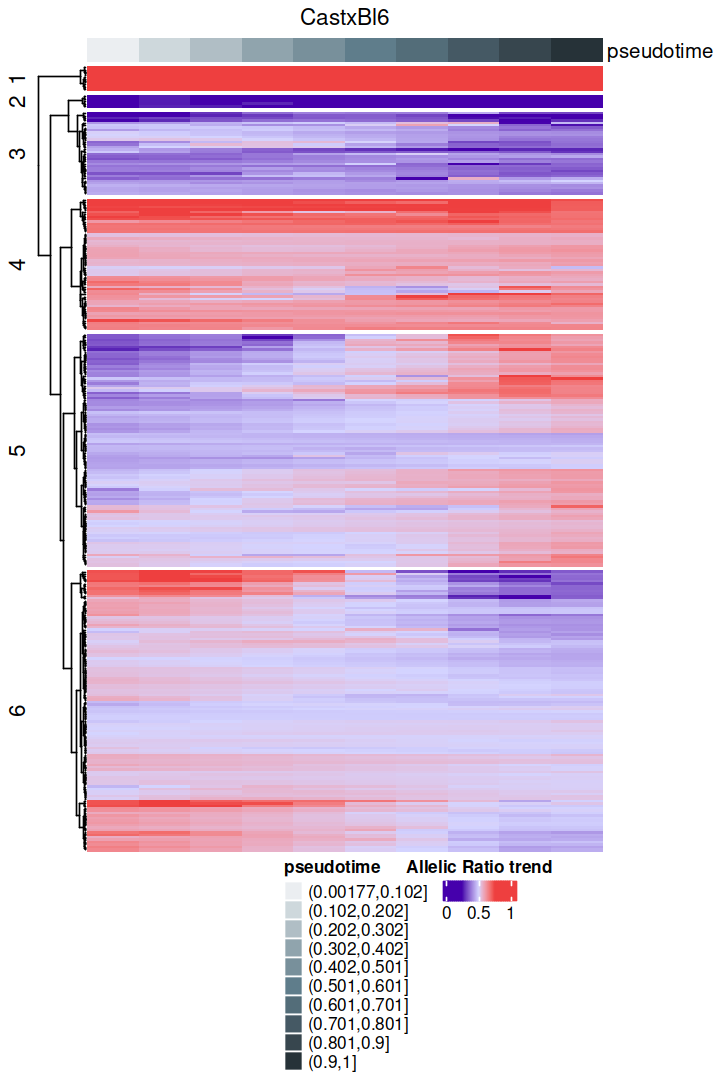

In [10]:
options(repr.plot.width = 6, repr.plot.height = 9)
draw(Cast_ht, heatmap_legend_side = "bottom", ht_gap = unit(0.1, "cm"),  merge_legends = T)   

Re-arrannging clusters

In [14]:
#clustering combination for genes with signif association between pseudotime and AR
Cast_r.dend <- row_dend(heatmap[[1]])
Cast_cl1 <- unlist(Cast_r.dend[[1]]) #BL6 biased
Cast_cl2 <- unlist(Cast_r.dend[[2]][[1]][[1]]) #Cast biased
Cast_cl3 <- unlist(Cast_r.dend[[2]][[1]][[2]]) 
Cast_cl4 <- unlist(Cast_r.dend[[2]][[2]][[1]])
Cast_cl5 <- unlist(Cast_r.dend[[2]][[2]][[2]][[1]])
Cast_cl6 <- unlist(Cast_r.dend[[2]][[2]][[2]][[2]])

Cast_trend.cl1 <- trend_imputed[[1]][Cast_cl1,]
Cast_trend.cl2 <- trend_imputed[[1]][Cast_cl2,]
Cast_trend.cl3 <- trend_imputed[[1]][Cast_cl3,]
Cast_trend.cl4 <- trend_imputed[[1]][Cast_cl4,]
Cast_trend.cl5 <- trend_imputed[[1]][Cast_cl5,]
Cast_trend.cl6 <- trend_imputed[[1]][Cast_cl6,]

Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_dend(ht)`.”


Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”


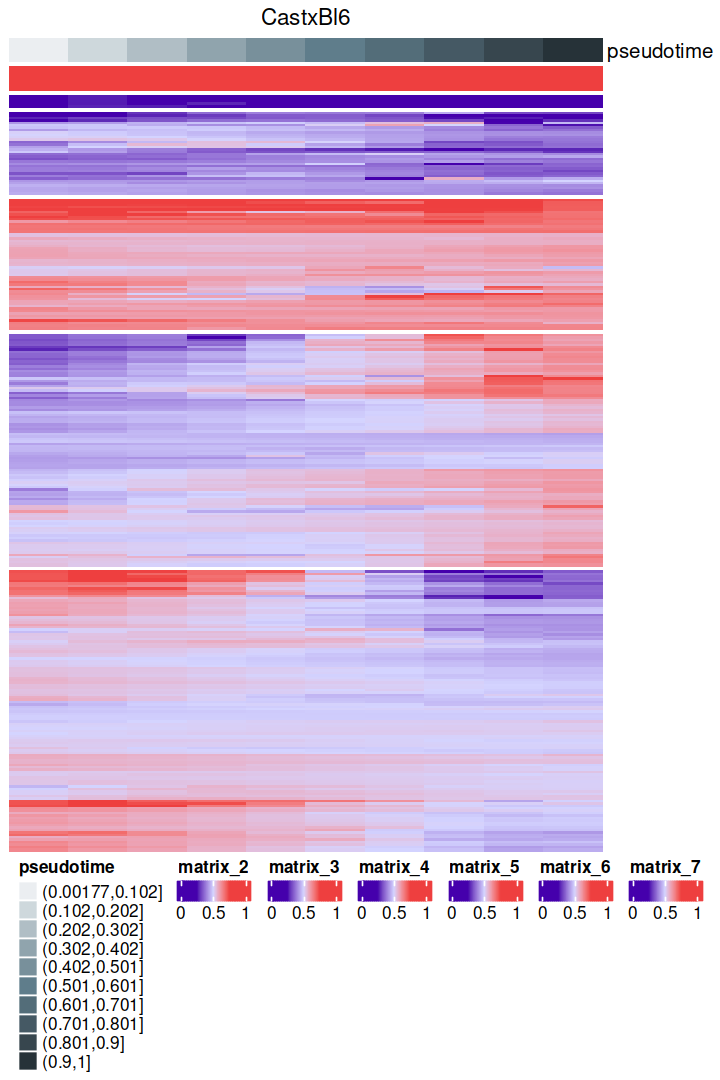

In [15]:
h1 <- ComplexHeatmap::Heatmap(Cast_trend.cl1, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F, top_annotation = top_ha,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)),
                              column_title = paste0(strains[1], "xBl6"))
h2 <- ComplexHeatmap::Heatmap(Cast_trend.cl2, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]), 
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)))
h3 <- ComplexHeatmap::Heatmap(Cast_trend.cl3, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)))
h4 <- ComplexHeatmap::Heatmap(Cast_trend.cl4, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)))
h5 <- ComplexHeatmap::Heatmap(Cast_trend.cl5, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)))
h6 <- ComplexHeatmap::Heatmap(Cast_trend.cl6, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)))
ht_list <- h1 %v% h2 %v% h3 %v% h4 %v% h5 %v% h6 
draw(ht_list, heatmap_legend_side = "bottom", ht_gap = unit(0.1, "cm"),  merge_legends = F)

Trend plots for each cluster

In [24]:
cluster_data <- list(Cast_trend.cl1, Cast_trend.cl4, Cast_trend.cl2, 
                     Cast_trend.cl3, Cast_trend.cl5, Cast_trend.cl6)

In [41]:
#package locfit is loaded to fit the local regression model which is then used to obtain standard errors
library(locfit)
#to estimate confidence interval locfit model us fitted for allelic ratio across pseudotime bins for all genes
cluster_data_long <- lapply(cluster_data, melt)
locfit_model <- lapply(cluster_data_long, function(q) locfit(q$value ~ lp(q$variable, nn = 0.1, h = 0.8)))
locfit_predict <- mapply(function(p, q) predict(p, lp(q$variable), se.fit = T), locfit_model, cluster_data_long, SIMPLIFY = F) 
cluster_data_long <- mapply(function(p,q) {p$se.fit <- q$se.fit; return(p)}, cluster_data_long, locfit_predict, SIMPLIFY = F)

se <- lapply(cluster_data_long, function(q) q %>% distinct(variable, .keep_all = T))        

#after lofit models are fitted locfit package needs to be detached, otherwise there's a conflict with default_smooth_function
detach("package:locfit", unload=TRUE)

#calculating mean values per bins - this is the trend line                         
AR_means <- lapply(cluster_data, colMeans)     
AR_plot_mean <- lapply(AR_means, function(q) q %>% data.frame() %>%
                  tibble::rownames_to_column(var = "pseudotime bin") %>%
                  rename_with(~"mean_AR", "."))

locfit 1.5-9.8 	 2023-06-11

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



In [42]:
#preparing data for plotting
AR_plot_mean <- mapply(function(p, q) plot_prep(p, q), AR_plot_mean, se, SIMPLIFY = F)

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


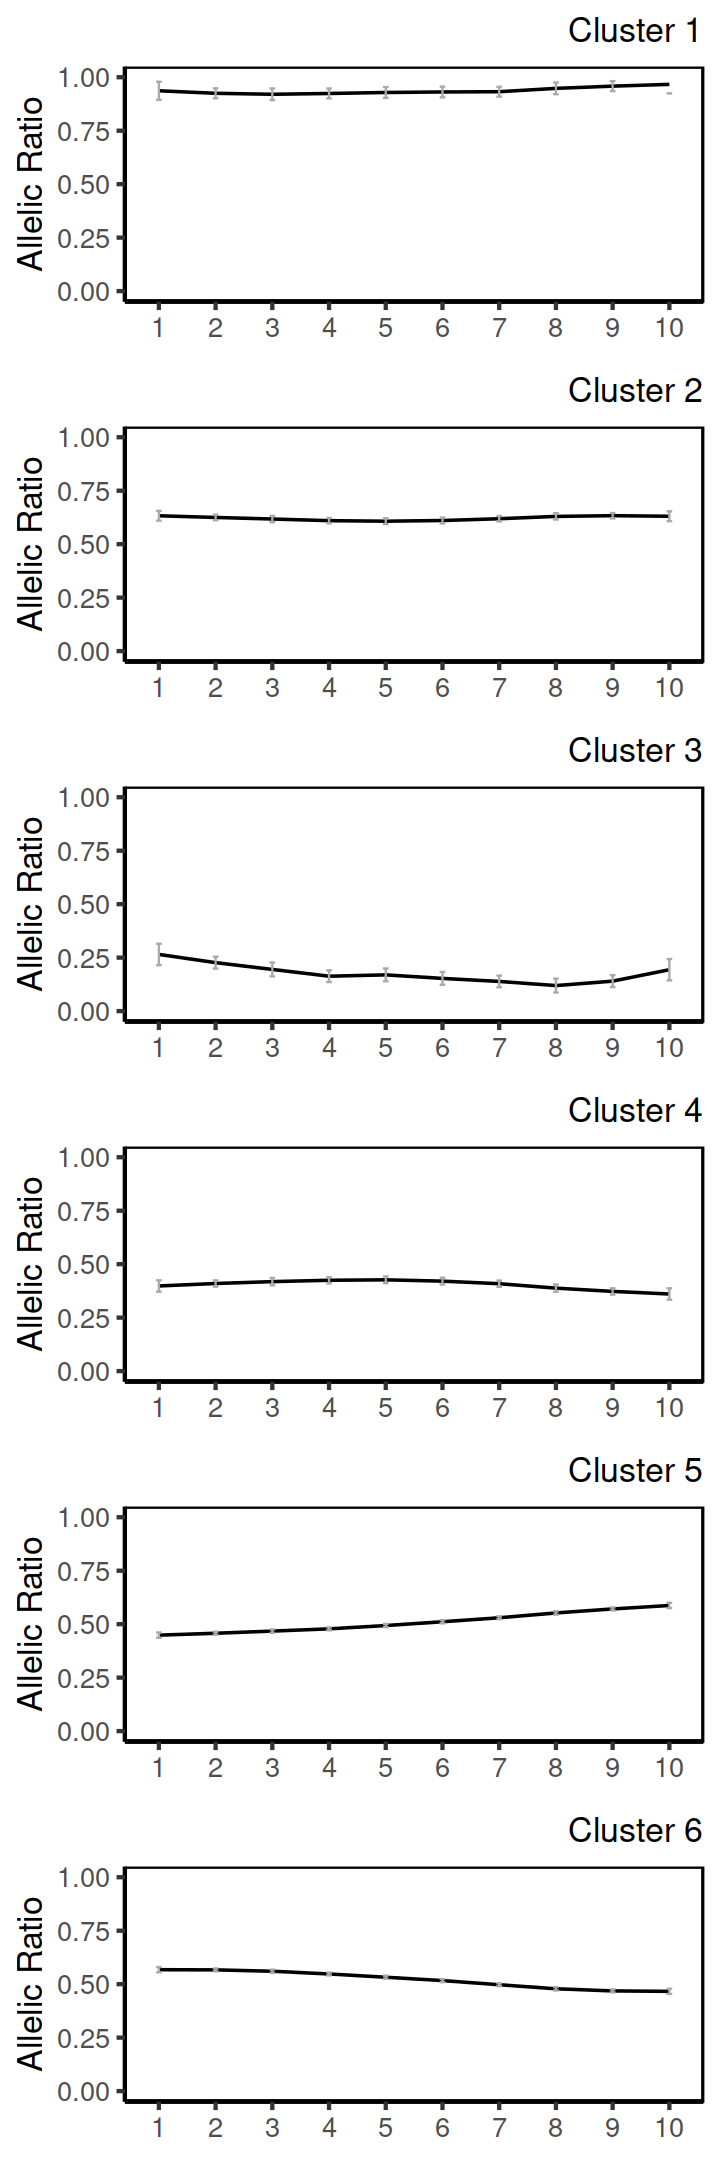

In [52]:
annot <- list("Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5", "Cluster 6")
options(repr.plot.width = 6, repr.plot.height = 18)
p <- mapply(function(p,q) plot_mean_ci(p) + labs(subtitle = q), 
            AR_plot_mean, annot, SIMPLIFY = F)
trend_plots <- do.call("grid.arrange", c(p, ncol = 1))

### MolfB6

In [54]:
Molf_ht <- ComplexHeatmap::Heatmap(trend_imputed[[2]], cluster_rows = hc[[2]], cluster_columns = F, 
                        show_row_names = F, show_column_names = F, name = "Allelic Ratio trend", 
                        heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)),
                        column_title = paste0(strains[2], "xBl6"), row_split = 7,
                        col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                        top_annotation = top_ha)
 

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


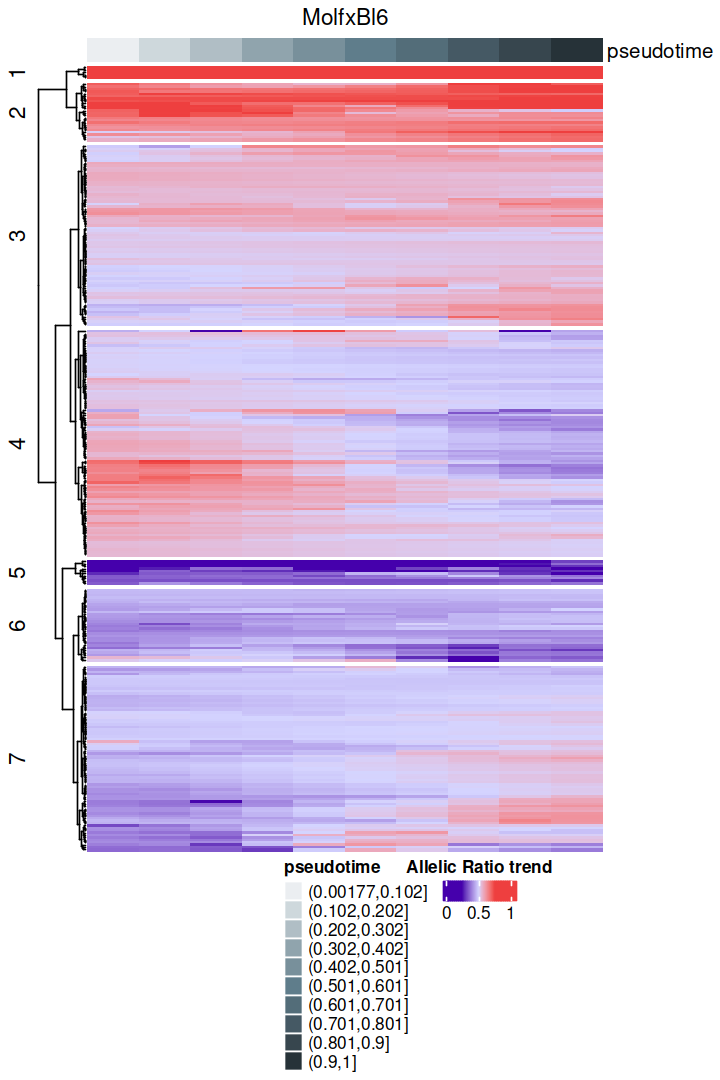

In [55]:
options(repr.plot.width = 6, repr.plot.height = 9)    
draw(Molf_ht, heatmap_legend_side = "bottom", ht_gap = unit(0.1, "cm"),  merge_legends = T)  

Re-arranging clusters

In [56]:
#clustering information for Molf
Molf_r.dend <- row_dend(heatmap[[2]])
Molf_cl1 <- unlist(Molf_r.dend[[1]][[1]]) #BL6 biased
Molf_cl2 <- unlist(Molf_r.dend[[1]][[2]]) 
Molf_cl3 <- unlist(Molf_r.dend[[2]][[1]][[1]]) 
Molf_cl4 <- unlist(Molf_r.dend[[2]][[1]][[2]])
Molf_cl5 <- unlist(Molf_r.dend[[2]][[2]][[1]]) #Cast biased
Molf_cl6 <- unlist(Molf_r.dend[[2]][[2]][[2]][[1]])
Molf_cl7 <- unlist(Molf_r.dend[[2]][[2]][[2]][[2]])

Molf_trend.cl1 <- trend_imputed[[2]][Molf_cl1,]
Molf_trend.cl2 <- trend_imputed[[2]][Molf_cl2,]
Molf_trend.cl3 <- trend_imputed[[2]][Molf_cl3,]
Molf_trend.cl4 <- trend_imputed[[2]][Molf_cl4,]
Molf_trend.cl5 <- trend_imputed[[2]][Molf_cl5,]
Molf_trend.cl6 <- trend_imputed[[2]][Molf_cl6,]
Molf_trend.cl7 <- trend_imputed[[2]][Molf_cl7,]

Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_dend(ht)`.”


In [57]:
#rearranging Molf heatmap by combining cluster 3 and 7
Molf_trend.cl1 <- trend_imputed[[2]][Molf_cl1,]
Molf_trend.cl2 <- trend_imputed[[2]][Molf_cl2,]
Molf_trend.cl3 <- trend_imputed[[2]][Molf_cl5,]
Molf_trend.cl4 <- trend_imputed[[2]][Molf_cl6,]
Molf_trend.cl5 <- trend_imputed[[2]][Molf_cl4,]
Molf_trend.cl6 <- trend_imputed[[2]][c(Molf_cl3, Molf_cl7),]

Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”


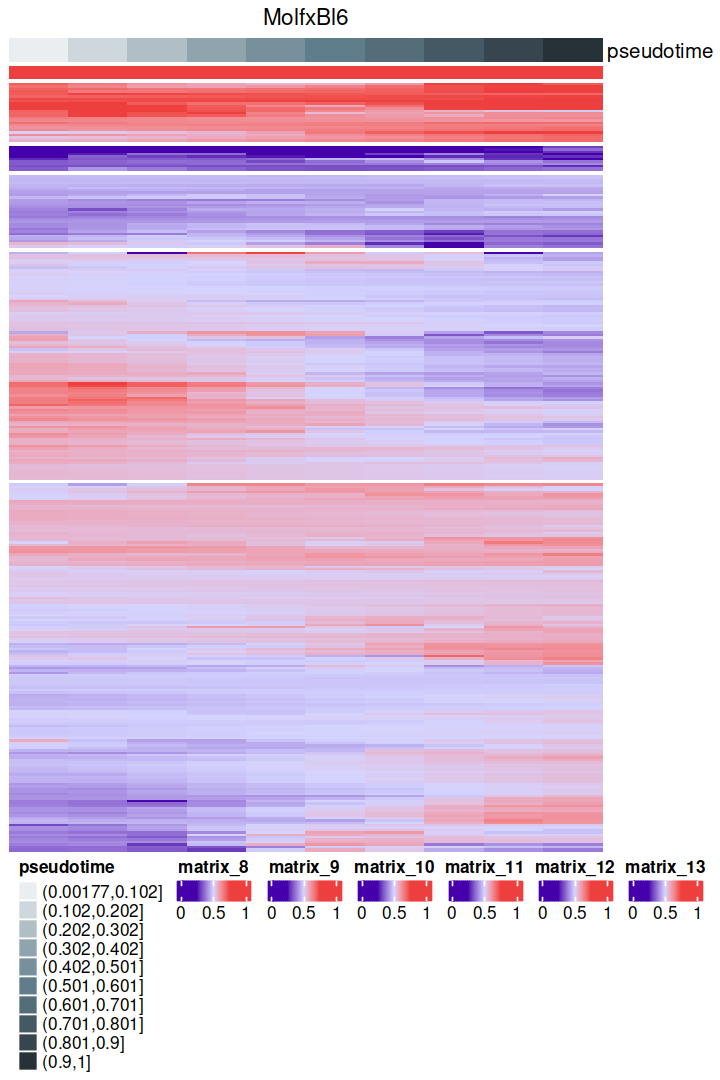

In [58]:
h1 <- ComplexHeatmap::Heatmap(Molf_trend.cl1, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F, top_annotation = top_ha,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)),
                              column_title = paste0(strains[2], "xBl6"))
h2 <- ComplexHeatmap::Heatmap(Molf_trend.cl2, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]), 
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)))
h3 <- ComplexHeatmap::Heatmap(Molf_trend.cl3, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)))
h4 <- ComplexHeatmap::Heatmap(Molf_trend.cl4, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)))
h5 <- ComplexHeatmap::Heatmap(Molf_trend.cl5, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)))
h6 <- ComplexHeatmap::Heatmap(Molf_trend.cl6, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)))
ht_list <- h1 %v% h2 %v% h3 %v% h4 %v% h5 %v% h6 
draw(ht_list, heatmap_legend_side = "bottom", ht_gap = unit(0.1, "cm"),  merge_legends = F)

In [59]:
cluster_data <- list(Molf_trend.cl1, Molf_trend.cl4, Molf_trend.cl2, 
                     Molf_trend.cl3, Molf_trend.cl5, Molf_trend.cl6)

In [60]:
#package locfit is loaded to fit the local regression model which is then used to obtain standard errors
library(locfit)
#to estimate confidence interval locfit model us fitted for allelic ratio across pseudotime bins for all genes
cluster_data_long <- lapply(cluster_data, melt)
locfit_model <- lapply(cluster_data_long, function(q) locfit(q$value ~ lp(q$variable, nn = 0.1, h = 0.8)))
locfit_predict <- mapply(function(p, q) predict(p, lp(q$variable), se.fit = T), locfit_model, cluster_data_long, SIMPLIFY = F) 
cluster_data_long <- mapply(function(p,q) {p$se.fit <- q$se.fit; return(p)}, cluster_data_long, locfit_predict, SIMPLIFY = F)

se <- lapply(cluster_data_long, function(q) q %>% distinct(variable, .keep_all = T))        

#after lofit models are fitted locfit package needs to be detached, otherwise there's a conflict with default_smooth_function
detach("package:locfit", unload=TRUE)

#calculating mean values per bins - this is the trend line                         
AR_means <- lapply(cluster_data, colMeans)     
AR_plot_mean <- lapply(AR_means, function(q) q %>% data.frame() %>%
                  tibble::rownames_to_column(var = "pseudotime bin") %>%
                  rename_with(~"mean_AR", "."))

locfit 1.5-9.8 	 2023-06-11

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



In [61]:
#preparing data for plotting
AR_plot_mean <- mapply(function(p, q) plot_prep(p, q), AR_plot_mean, se, SIMPLIFY = F)

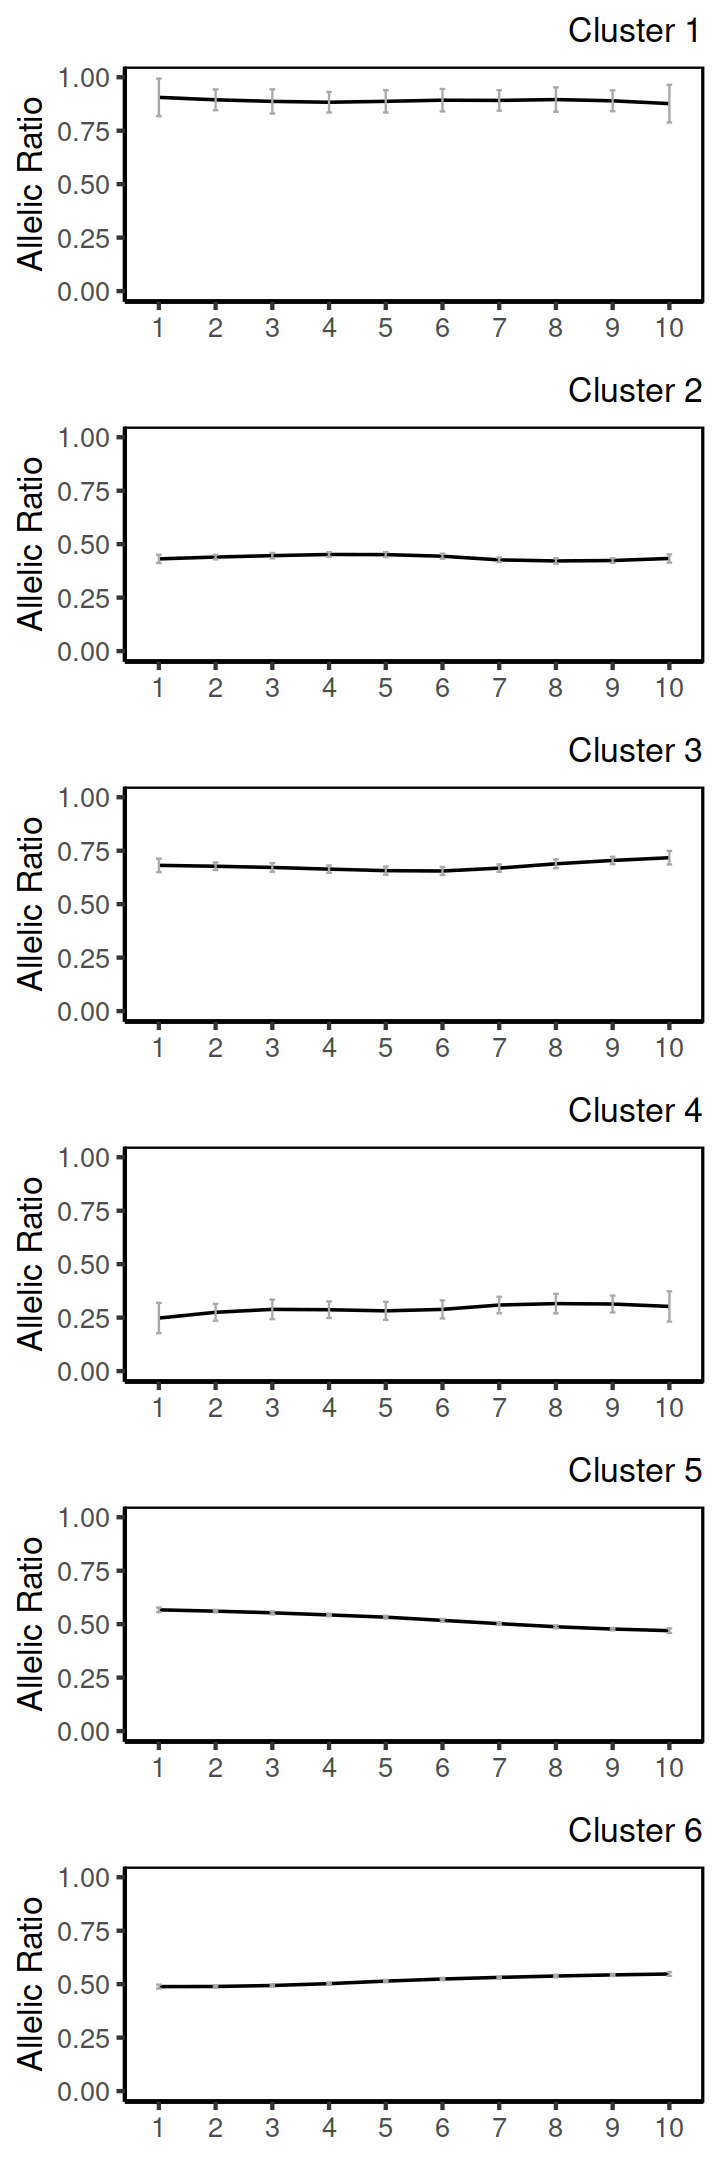

In [62]:
options(repr.plot.width = 6, repr.plot.height = 18)
p <- mapply(function(p,q) plot_mean_ci(p) + labs(subtitle = q), 
            AR_plot_mean, annot, SIMPLIFY = F)
trend_plots <- do.call("grid.arrange", c(p, ncol = 1))

### PwkB6

In [64]:
Pwk_ht <- ComplexHeatmap::Heatmap(trend_imputed[[3]], cluster_rows = hc[[3]], cluster_columns = F, 
                        show_row_names = F, show_column_names = F, name = "Allelic Ratio trend", 
                        heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)),
                        column_title = paste0(strains[3], "xBl6"), row_split = 7,
                        col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                        top_annotation = top_ha)

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


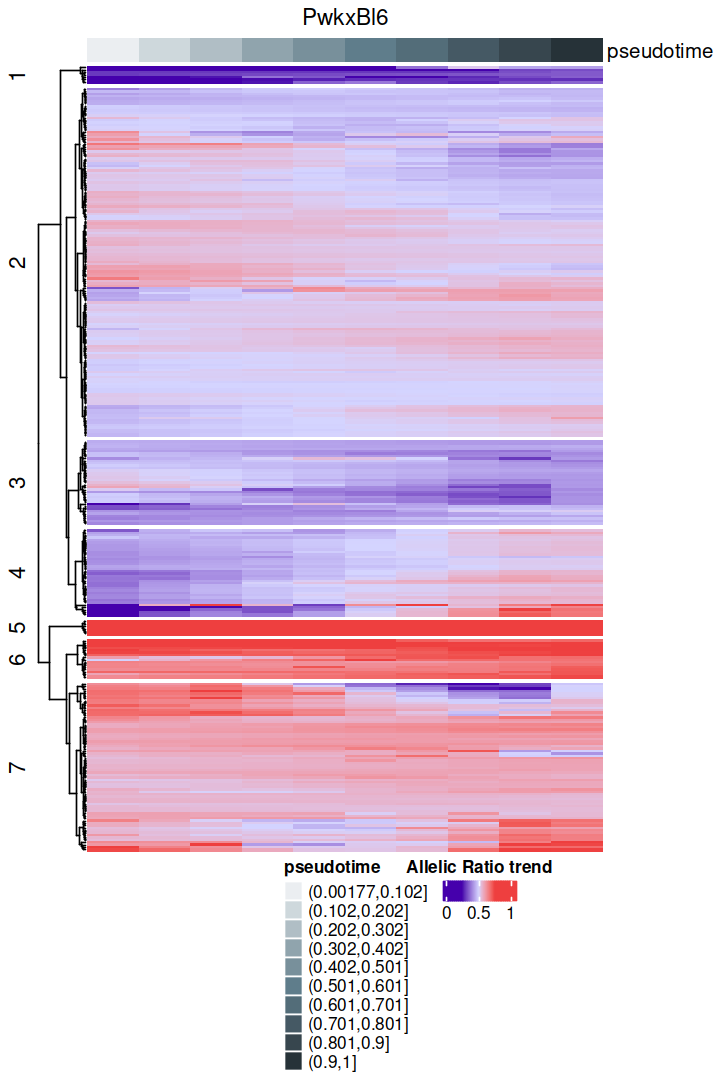

In [65]:
options(repr.plot.width = 6, repr.plot.height = 9)    
draw(Pwk_ht, heatmap_legend_side = "bottom", ht_gap = unit(0.1, "cm"),  merge_legends = T)  

Re-arranging clusters

In [68]:
#rearranging Pwk clusters
Pwk_r.dend <- row_dend(heatmap[[3]])
Pwk_cl1 <- unlist(Pwk_r.dend[[1]][[1]]) #Pwk biased
Pwk_cl2 <- unlist(Pwk_r.dend[[1]][[2]][[1]][[1]][[1]][[1]]) #from Bl6 to Pwk faint isolate into new
Pwk_cl3 <- unlist(Pwk_r.dend[[1]][[2]][[1]][[1]][[1]][[2]]) 
Pwk_cl4 <- unlist(Pwk_r.dend[[1]][[2]][[1]][[1]][[2]]) 
Pwk_cl5 <- unlist(Pwk_r.dend[[1]][[2]][[1]][[2]])  #from Pwk to Bl6 faint
Pwk_cl6 <- unlist(Pwk_r.dend[[1]][[2]][[2]][[1]][[1]]) #from Bl6 to Pwk (or Pwk faint)
Pwk_cl7 <- unlist(Pwk_r.dend[[1]][[2]][[2]][[1]][[2]]) #from Bl6 to Pwk (or Pwk faint) isolate into new
Pwk_cl8 <- unlist(Pwk_r.dend[[1]][[2]][[2]][[2]]) #from Pwk to Bl6
Pwk_cl9 <- unlist(Pwk_r.dend[[2]][[1]]) #Bl6 biased
Pwk_cl10 <- unlist(Pwk_r.dend[[2]][[2]][[1]]) #Bl6 biased mild
Pwk_cl11 <- unlist(Pwk_r.dend[[2]][[2]][[2]][[1]])
Pwk_cl12 <- unlist(Pwk_r.dend[[2]][[2]][[2]][[2]])

Pwk_trend.cl1 <- trend_imputed[[3]][Pwk_cl1,]
Pwk_trend.cl2 <- trend_imputed[[3]][Pwk_cl2,]
Pwk_trend.cl3 <- trend_imputed[[3]][Pwk_cl3,]
Pwk_trend.cl4 <- trend_imputed[[3]][Pwk_cl4,]
Pwk_trend.cl5 <- trend_imputed[[3]][Pwk_cl5,]
Pwk_trend.cl6 <- trend_imputed[[3]][Pwk_cl6,]
Pwk_trend.cl7 <- trend_imputed[[3]][Pwk_cl7,]
Pwk_trend.cl8 <- trend_imputed[[3]][Pwk_cl8,]
Pwk_trend.cl9 <- trend_imputed[[3]][Pwk_cl9,]
Pwk_trend.cl10 <- trend_imputed[[3]][Pwk_cl10,]
Pwk_trend.cl11 <- trend_imputed[[3]][Pwk_cl11,]
Pwk_trend.cl12 <- trend_imputed[[3]][Pwk_cl12,]

Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_dend(ht)`.”


In [69]:
#Using more granular cluster rearranging Pwk heatmap
Pwk_trend.cl1 <- trend_imputed[[3]][Pwk_cl9,]
Pwk_trend.cl2 <- trend_imputed[[3]][Pwk_cl10,]
Pwk_trend.cl3 <- trend_imputed[[3]][Pwk_cl1,]
Pwk_trend.cl4 <- trend_imputed[[3]][c(Pwk_cl2, Pwk_cl7),]
Pwk_trend.cl5 <- trend_imputed[[3]][c(Pwk_cl3, Pwk_cl4, Pwk_cl6, Pwk_cl11),]
Pwk_trend.cl6 <- trend_imputed[[3]][c(Pwk_cl8, Pwk_cl5, Pwk_cl12),]

Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”


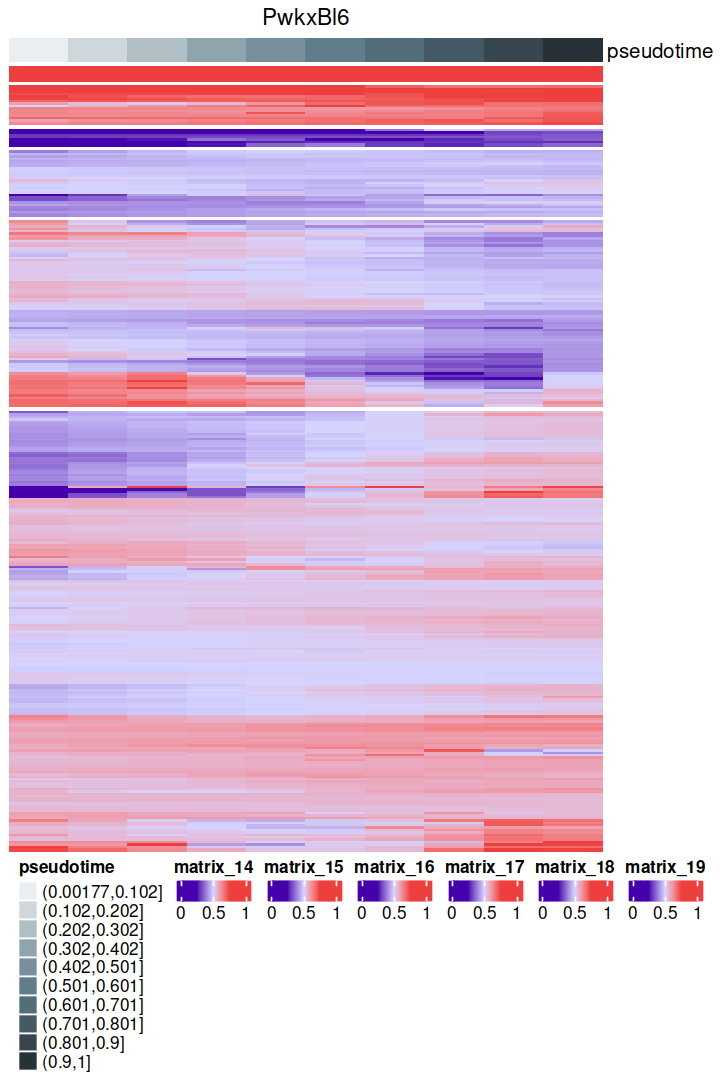

In [70]:
h1 <- ComplexHeatmap::Heatmap(Pwk_trend.cl1, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F, top_annotation = top_ha,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)),
                              column_title = paste0(strains[3], "xBl6"))
h2 <- ComplexHeatmap::Heatmap(Pwk_trend.cl2, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]), 
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)))
h3 <- ComplexHeatmap::Heatmap(Pwk_trend.cl3, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)))
h4 <- ComplexHeatmap::Heatmap(Pwk_trend.cl4, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)))
h5 <- ComplexHeatmap::Heatmap(Pwk_trend.cl5, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)))
h6 <- ComplexHeatmap::Heatmap(Pwk_trend.cl6, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)))
ht_list <- h1 %v% h2 %v% h3 %v% h4 %v% h5 %v% h6 
draw(ht_list, heatmap_legend_side = "bottom", ht_gap = unit(0.1, "cm"),  merge_legends = F)

In [71]:
cluster_data <- list(Pwk_trend.cl1, Pwk_trend.cl4, Pwk_trend.cl2, 
                     Pwk_trend.cl3, Pwk_trend.cl5, Pwk_trend.cl6)

In [72]:
#package locfit is loaded to fit the local regression model which is then used to obtain standard errors
library(locfit)
#to estimate confidence interval locfit model us fitted for allelic ratio across pseudotime bins for all genes
cluster_data_long <- lapply(cluster_data, melt)
locfit_model <- lapply(cluster_data_long, function(q) locfit(q$value ~ lp(q$variable, nn = 0.1, h = 0.8)))
locfit_predict <- mapply(function(p, q) predict(p, lp(q$variable), se.fit = T), locfit_model, cluster_data_long, SIMPLIFY = F) 
cluster_data_long <- mapply(function(p,q) {p$se.fit <- q$se.fit; return(p)}, cluster_data_long, locfit_predict, SIMPLIFY = F)

se <- lapply(cluster_data_long, function(q) q %>% distinct(variable, .keep_all = T))        

#after lofit models are fitted locfit package needs to be detached, otherwise there's a conflict with default_smooth_function
detach("package:locfit", unload=TRUE)

#calculating mean values per bins - this is the trend line                         
AR_means <- lapply(cluster_data, colMeans)     
AR_plot_mean <- lapply(AR_means, function(q) q %>% data.frame() %>%
                  tibble::rownames_to_column(var = "pseudotime bin") %>%
                  rename_with(~"mean_AR", "."))

locfit 1.5-9.8 	 2023-06-11

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



In [73]:
#preparing data for plotting
AR_plot_mean <- mapply(function(p, q) plot_prep(p, q), AR_plot_mean, se, SIMPLIFY = F)

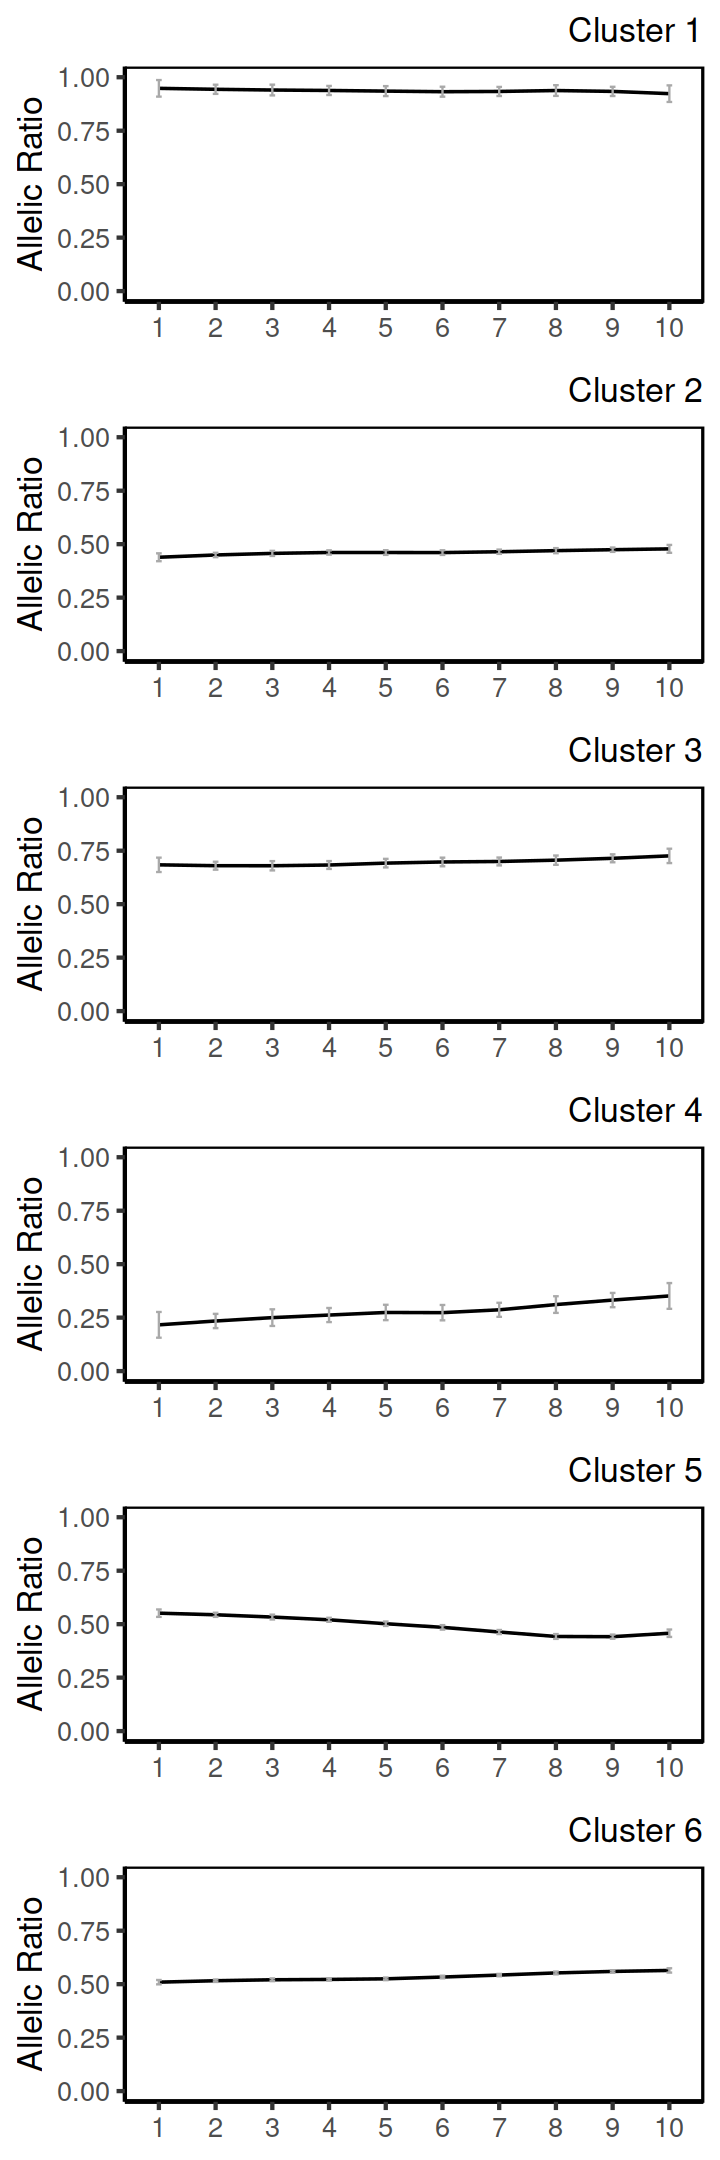

In [74]:
options(repr.plot.width = 6, repr.plot.height = 18)
p <- mapply(function(p,q) plot_mean_ci(p) + labs(subtitle = q), 
            AR_plot_mean, annot, SIMPLIFY = F)
trend_plots <- do.call("grid.arrange", c(p, ncol = 1))

### SpretB6

In [78]:
Spret_ht <- ComplexHeatmap::Heatmap(trend_imputed[[4]], cluster_rows = hc[[4]], cluster_columns = F, 
                        show_row_names = F, show_column_names = F, name = "Allelic Ratio trend", 
                        heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)),
                        column_title = paste0(strains[4], "xBl6"), row_split = 6,
                        col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                        top_annotation = top_ha)

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


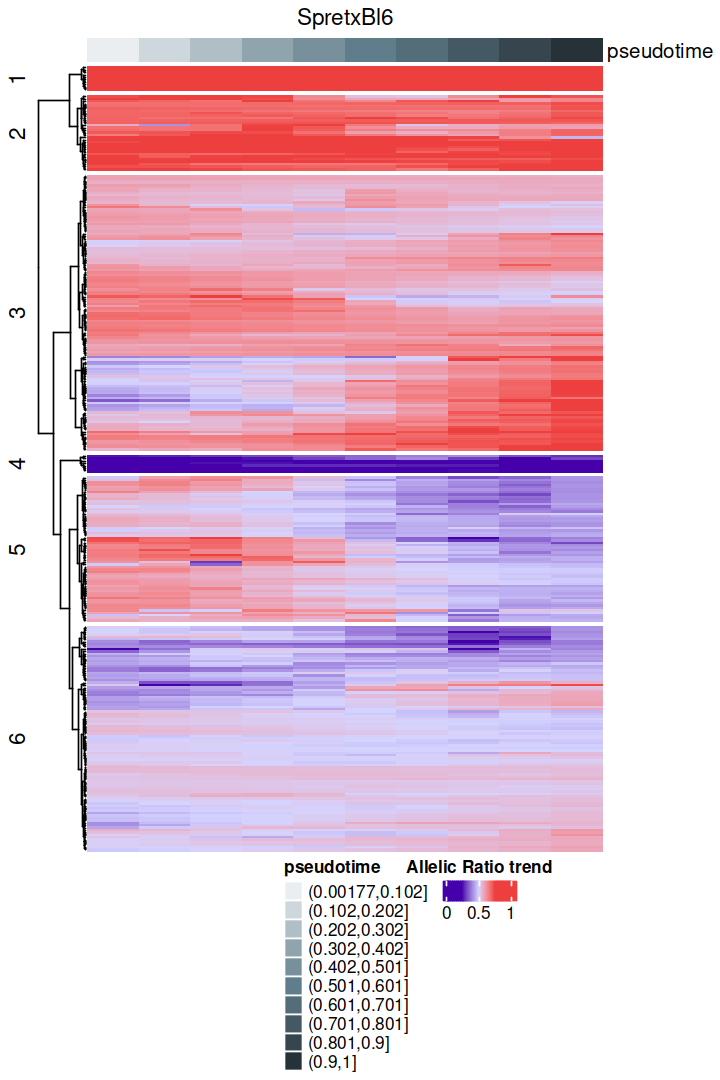

In [79]:
options(repr.plot.width = 6, repr.plot.height = 9)    
draw(Spret_ht, heatmap_legend_side = "bottom", ht_gap = unit(0.1, "cm"),  merge_legends = T)  

In [80]:
#clustering information for Spret
Spret_r.dend <- row_dend(heatmap[[4]])
Spret_cl1 <- unlist(Spret_r.dend[[1]][[1]]) #Bl6 bias
Spret_cl2 <- unlist(Spret_r.dend[[1]][[2]]) 
Spret_cl3 <- unlist(Spret_r.dend[[2]][[1]][[1]]) 
Spret_cl4 <- unlist(Spret_r.dend[[2]][[1]][[2]]) 
Spret_cl5 <- unlist(Spret_r.dend[[2]][[2]][[1]]) #Spret bias
Spret_cl6 <- unlist(Spret_r.dend[[2]][[2]][[2]][[1]])
Spret_cl7 <- unlist(Spret_r.dend[[2]][[2]][[2]][[2]][[1]])
Spret_cl8 <- unlist(Spret_r.dend[[2]][[2]][[2]][[2]][[2]])

Spret_trend.cl1 <- trend_imputed[[4]][Spret_cl1,]
Spret_trend.cl2 <- trend_imputed[[4]][Spret_cl2,]
Spret_trend.cl3 <- trend_imputed[[4]][Spret_cl3,]
Spret_trend.cl4 <- trend_imputed[[4]][Spret_cl4,]
Spret_trend.cl5 <- trend_imputed[[4]][Spret_cl5,]
Spret_trend.cl6 <- trend_imputed[[4]][Spret_cl6,]
Spret_trend.cl7 <- trend_imputed[[4]][Spret_cl7,]
Spret_trend.cl8 <- trend_imputed[[4]][Spret_cl8,]

Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_dend(ht)`.”


In [81]:
Spret_trend.cl1 <- trend_imputed[[4]][Spret_cl1,]
Spret_trend.cl2 <- trend_imputed[[4]][Spret_cl2,]
Spret_trend.cl3 <- trend_imputed[[4]][Spret_cl5,]
Spret_trend.cl4 <- trend_imputed[[4]][Spret_cl7,]
Spret_trend.cl5 <- trend_imputed[[4]][c(Spret_cl3, Spret_cl6),]
Spret_trend.cl6 <- trend_imputed[[4]][c(Spret_cl4, Spret_cl8),]

Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”


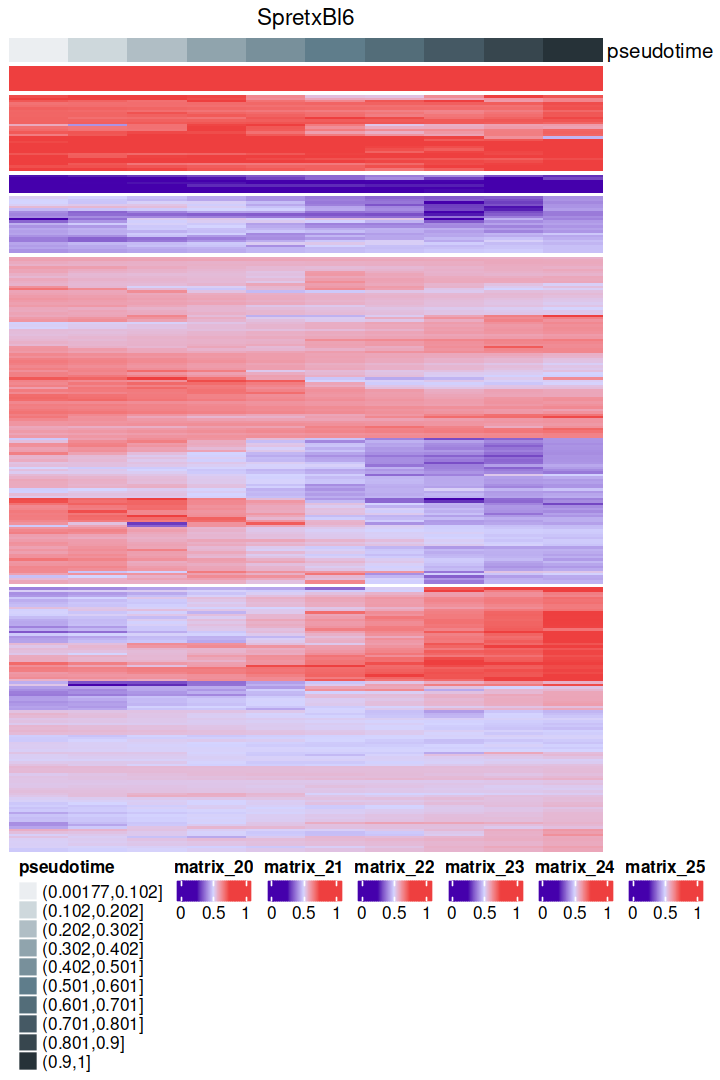

In [82]:
h1 <- ComplexHeatmap::Heatmap(Spret_trend.cl1, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F, top_annotation = top_ha,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)),
                             column_title = paste0(strains[4], "xBl6"))
h2 <- ComplexHeatmap::Heatmap(Spret_trend.cl2, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]), 
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)))
h3 <- ComplexHeatmap::Heatmap(Spret_trend.cl3, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)))
h4 <- ComplexHeatmap::Heatmap(Spret_trend.cl4, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)))
h5 <- ComplexHeatmap::Heatmap(Spret_trend.cl5, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)))
h6 <- ComplexHeatmap::Heatmap(Spret_trend.cl6, cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = F,
                              col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]),
                              heatmap_legend_param = list(direction = "horizontal", title_position = "topcenter", at = seq(0, 1, 0.5)))

ht_list <- h1 %v% h2 %v% h3 %v% h4 %v% h5 %v% h6 
draw(ht_list, heatmap_legend_side = "bottom", ht_gap = unit(0.1, "cm"),  merge_legends = T)

In [83]:
cluster_data <- list(Spret_trend.cl1, Spret_trend.cl4, Spret_trend.cl2, 
                     Spret_trend.cl3, Spret_trend.cl5, Spret_trend.cl6)

In [84]:
#package locfit is loaded to fit the local regression model which is then used to obtain standard errors
library(locfit)
#to estimate confidence interval locfit model us fitted for allelic ratio across pseudotime bins for all genes
cluster_data_long <- lapply(cluster_data, melt)
locfit_model <- lapply(cluster_data_long, function(q) locfit(q$value ~ lp(q$variable, nn = 0.1, h = 0.8)))
locfit_predict <- mapply(function(p, q) predict(p, lp(q$variable), se.fit = T), locfit_model, cluster_data_long, SIMPLIFY = F) 
cluster_data_long <- mapply(function(p,q) {p$se.fit <- q$se.fit; return(p)}, cluster_data_long, locfit_predict, SIMPLIFY = F)

se <- lapply(cluster_data_long, function(q) q %>% distinct(variable, .keep_all = T))        

#after lofit models are fitted locfit package needs to be detached, otherwise there's a conflict with default_smooth_function
detach("package:locfit", unload=TRUE)

#calculating mean values per bins - this is the trend line                         
AR_means <- lapply(cluster_data, colMeans)     
AR_plot_mean <- lapply(AR_means, function(q) q %>% data.frame() %>%
                  tibble::rownames_to_column(var = "pseudotime bin") %>%
                  rename_with(~"mean_AR", "."))

locfit 1.5-9.8 	 2023-06-11

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



In [85]:
#preparing data for plotting
AR_plot_mean <- mapply(function(p, q) plot_prep(p, q), AR_plot_mean, se, SIMPLIFY = F)

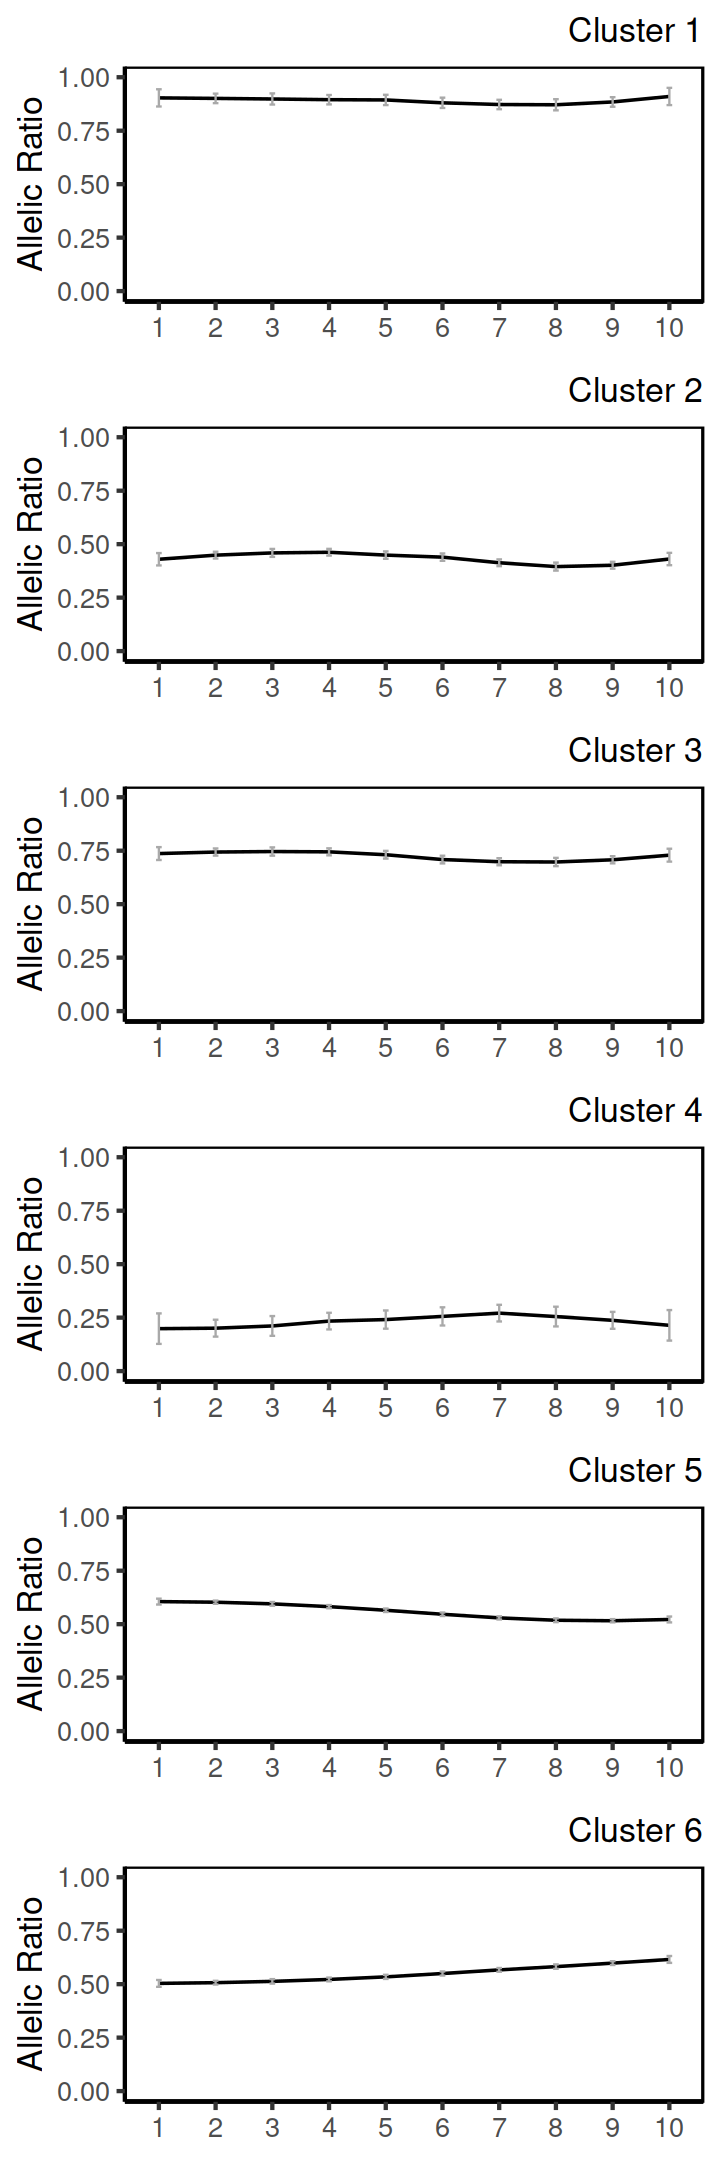

In [86]:
options(repr.plot.width = 6, repr.plot.height = 18)
p <- mapply(function(p,q) plot_mean_ci(p) + labs(subtitle = q), 
            AR_plot_mean, annot, SIMPLIFY = F)
trend_plots <- do.call("grid.arrange", c(p, ncol = 1))